In [63]:
# For changing directories to C++ programming and runnning files
import subprocess as sp
import os

# since using WSL2
os.environ['MPLCONFIGDIR'] = '/tmp/'

from multiprocessing import Pool

# Typical functionality for data manipulation and generation of latin hypercube
import numpy as np
from pyDOE import lhs
import emcee

# Gaussian Process emulator 
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.special as special
import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

# for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
sns.set("notebook")
%matplotlib inline
plt.style.use('default')

# data storage
import pandas as pd

In [64]:
import sys
print(sys.platform)

linux


In [65]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [66]:
# My costumizations for plots
import matplotlib.font_manager
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Computer Modern Roman']})
rc('text', usetex=True)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def costumize_axis(ax, x_title, y_title):
    ax.set_xlabel(x_title, fontsize=24)
    ax.set_ylabel(y_title, fontsize=24)
    ax.tick_params(axis='both', labelsize=18, top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=8)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis='both', which='minor', direction='in', length=4, top=True, right=True)
    return ax

In [67]:
# Others costumizations for plots
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('white')
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    costumize_axis(ax1, '', '')
    costumize_axis(ax2, '', '')
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y, color='blue')
    ax1.hist(X, color='blue', density=True)
    ax2.hist(Y, color='blue', orientation='horizontal', density=True)
    costumize_axis(ax, nameX, nameY)

# Defining the Model
This was actually done in `C++`, and this bit of code interface with the executable.

In [68]:
def PrintParametersFile(params_dict):
    '''
    Function ouputs file "params.txt" to the Code/util folder to be used by the
    Code/build/exact_solution.x program
    '''
    os.chdir('/mnt/c/Users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code')
    with open('./utils/params.txt', 'w') as fout:
        fout.write(f'tau_0 {params_dict["tau_0"]}\n')
        fout.write(f'Lambda_0 {params_dict["Lambda_0"]}\n')
        fout.write(f'alpha_0 {params_dict["alpha_0"]}\n')
        fout.write(f'xi_0 {params_dict["xi_0"]}\n')
        fout.write(f'ul {params_dict["tau_f"]}\n')
        fout.write(f'll {params_dict["tau_0"]}\n')
        fout.write(f'mass {params_dict["mass"]}\n')
        fout.write(f'eta_s {params_dict["eta_s"]}\n')
        fout.write(f'pl0 {params_dict["pl0"]}\n')
        fout.write(f'pt0 {params_dict["pt0"]}\n')
        fout.write(f'TYPE {params_dict["hydro_type"]}')
    os.chdir('/mnt/c/Users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/scripts/')
    return 

def RunHydroSimulation():
    '''
    Function calls the C++ excecutable that run hydro calculations
    '''
    os.chdir('../')
    sp.run(['./build/exact_solution.x'], shell=True)
    os.chdir('scripts/')
    return

# Gaussian Process Regression
The training points and validation plots

In [69]:
# Need to define latin hypercube sampling points and then run hydrodynamic simulation for all.
num_parameters_in_GP = 1 # Should be minimum of two to take into account relaxation time constant and ending time
GP_parameter_names = ['eta_s'] # Expand as needed
GP_parameter_names_math = [r'$\eta_s$']
# Make sure that order of ranges variable matches how they appear in names_of_GP_parameters
GP_parameter_ranges = np.array([[1 / (4 * np.pi), 10 / (4 * np.pi)]])
num_design_points = 40 * num_parameters_in_GP
unit = lhs(n=num_parameters_in_GP, samples=num_design_points, criterion='maximin')
GP_design_points = GP_parameter_ranges[:, 0] + unit * (GP_parameter_ranges[:, 1] - GP_parameter_ranges[:, 0])
GP_design_range = GP_parameter_ranges[:,1] - GP_parameter_ranges[:,0]
print(GP_design_range)

[0.71619724]


(array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 array([0.08354623, 0.15445188, 0.22535753, 0.29626318, 0.36716883,
        0.43807449, 0.50898014, 0.57988579, 0.65079144, 0.72169709,
        0.79260274]),
 <BarContainer object of 10 artists>)

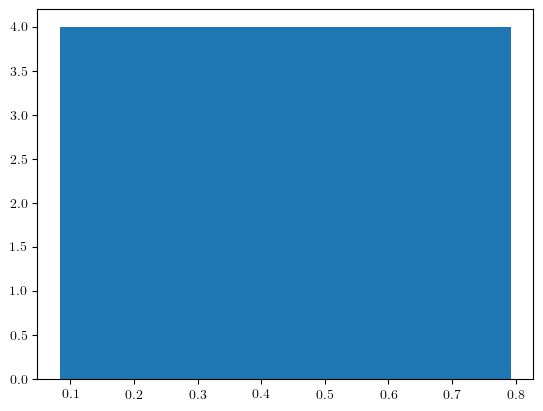

In [70]:
# fig, ax = plt.subplots(figsize=(10, 10))
# fig.patch.set_facecolor('white')
# ax.scatter(GP_design_points[:, 0], GP_design_points[:, 1])
# costumize_axis(ax, r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')

#hist_1d_2d(GP_design_points[:, 0], GP_design_points[:, 1], r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')
plt.hist(GP_design_points)

In [71]:
def design_log_prior(model_parameters, design_range):
    '''c
    Parameters:
    ------------
    model_parameters    - 1d-array with shape (n,). Value of parameters used to evaluate model
    design_range        - 2d-array with shape (n,2). Give upper and lower limits of parameter values
    '''
    X  = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= np.array(design_range)[:,0])
    upper = np.all(X <= np.array(design_range)[:,1])

    if (lower and upper):
        return 0
    else:
        return -np.inf

def design_log_likelihood(y, cov):
    '''
    Parameters:
    ------------
    y   - 1d-array with shape (n,)
    cov - 2d-array with shape (n,n)
    '''
    # Use Cholesky decomposition for efficient lin alg algo
    L, info = lapack.dpotrf(cov, clean=True)

    if (info < 0):
        raise print('Error occured in computation of Cholesky decomposition')

    # Solve equation L*b=y
    b, info = lapack.dpotrs(L, np.array(y))

    if (info != 0):
        raise print('Error in inverting matrix equation')

    if np.all(L.diagonal() > 0):
        return -0.5 * np.dot(y, b) - np.log(L.diagonal()).sum()
    else:
        raise print('Diagonal has negative entry')

def design_log_posterior(model_parameters, design_range, design_points, truth, truth_error):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,)
    design_range        - 2d-array like (n,2)
    hydro_name          - string containing hydro theory: 'ce', 'dnmr', 'vah', 'mvah'
    GP_emulatr          - dictionary(hydro_name: emulator_list), 
                            emulator_list[0] - energery density
                            emulator_list[1] - shear stress
                            emulator_list[2] - bulk stress
    '''
    y = design_points - truth
    cov = np.eye(len(design_points))
    cov += np.diag(truth_error)

    return design_log_prior(model_parameters, design_range) + design_log_likelihood(y, cov)


In [72]:
#default values for parameters
params = {
    'tau_0': 0.1,
    'Lambda_0': 1.647204044,
    'xi_0': -0.8320365099,
    'alpha_0': 0.654868759,
    'tau_f': 12.1,
    'mass': 1.015228426,
    'eta_s': 0.23873241463784,
    'pl0': 8.1705525351457684,
    'pt0': 1.9875332965147663,
    'hydro_type': 0
}

In [73]:
# function run runs hydro code to generate simualtion results for a set of 
# given parameters
def ProcessHydro(parameter_names, simulation_points, store_whole_file=False):
    out_list = []
    def GetFromOutputFiles(hydro_type):
        if hydro_type == 0:
            prefix = '../output/CE_hydro/'
            suffix = ''
        elif hydro_type == 1:
            prefix = '../output/DNMR_hydro/'
            suffix = ''
        elif hydro_type == 2:
            prefix = '../output/aniso_hydro/'
            suffix = ''
        elif hydro_type == 3:
            prefix = '../output/aniso_hydro/'
            suffix = '2'
        
        if store_whole_file:
            f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r')
            f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r')
            f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r')

            return [f_e.readlines(), f_pi.readlines(), f_Pi.readlines()]
        else:
            f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r')
            last_e = f_e.readlines()[-1]
            tau, e = last_e.split()[0], last_e.split()[1]
            f_e.close(); del last_e

            f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r')
            last_pi = f_pi.readlines()[-1]
            pi = last_pi.split()[1]
            f_pi.close(); del last_pi

            f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r')
            last_Pi = f_Pi.readlines()[-1]
            Pi = last_Pi.split()[1]
            f_Pi.close(); del last_Pi

            temp_list = [float(tau), float(e), float(pi), float(Pi)]
            return temp_list

    def GetExactResults():
        f_exact = open('../output/exact/MCMC_calculation_moments.dat','r')
        if store_whole_file:
            return f_exact.readlines()
        else:
            t, e, pl, pt, p = f_exact.readlines()[-1].split()
            pi = (float(pt) - float(pl)) / 1.5
            Pi = (2 *  float(pt) + float(pl)) / 3 - float(p)
            temp_list = [float(t), float(e), pi, Pi]
            return temp_list

    if len(simulation_points) > len(parameter_names):
        for parameters in simulation_points:
            for i, name in enumerate(parameter_names):
                params[name] = parameters[i]
            PrintParametersFile(params)
            RunHydroSimulation()
            if params['hydro_type'] == 4:
                out_list.append(GetExactResults())
            else:
                out_list.append(GetFromOutputFiles(params['hydro_type']))

    else:
        for i, name in enumerate(parameter_names):
            params[name] = simulation_points[i]
        PrintParametersFile(params)
        RunHydroSimulation()
        if params['hydro_type'] == 4:
            return GetExactResults()
        else:
            return GetFromOutputFiles(params['hydro_type'])

    return out_list


In [74]:
# ce = []    # 0
# dnmr = []  # 1
# vah = []   # 2
# mvah = []  # 3
hydro_mode = [0, 1, 2, 3]
out_lists = []
read_in_simulation = True   # should false for first run
if read_in_simulation:
    with open('design_points_n=1.dat','r') as f:
        GP_design_points = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])

    with open('ce_simulation_points_n=1.dat', 'r') as f:
        lines = f.readlines()
        ce_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])

    with open('dnmr_simulation_points_n=1.dat', 'r') as f:
        lines = f.readlines()
        dnmr_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])

    with open('vah_simulation_points_n=1.dat', 'r') as f:
        lines = f.readlines()
        vah_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])

    with open('mvah_simulation_points_n=1.dat', 'r') as f:
        lines = f.readlines()
        mvah_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])
else:
    for i in range(4):
        params['hydro_type'] = i
        out_lists.append(ProcessHydro(parameter_names=GP_parameter_names, simulation_points=GP_design_points))

    print(os.getcwd())
    with open('design_points_n=1.dat','w') as f:
        for line in GP_design_points:
            for entry in line:
                f.write(f'{entry} ')
            f.write(f'\n')

    with open('ce_simulation_points_n=1.dat', 'w') as f:
        for line in out_lists[0]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')

    with open('dnmr_simulation_points_n=1.dat', 'w') as f:
        for line in out_lists[1]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')

    with open('vah_simulation_points_n=1.dat', 'w') as f:
        for line in out_lists[2]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')

    with open('mvah_simulation_points_n=1.dat', 'w') as f:
        for line in out_lists[3]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')
    

In [75]:
hydro_lists = np.array([ce_simulation, dnmr_simulation, vah_simulation, mvah_simulation])

In [94]:
truth_params = [5 / (4 * np.pi)]; print(truth_params)
params['hydro_type'] = 4
params['tau_f'] = 12.1
truth = np.array(ProcessHydro(GP_parameter_names, truth_params))
truth_error = 0.05 * truth

[0.3978873577297384]


In [92]:
# make posteriors for GP_design points, given eta_s = 5. / (4 pi) and tau_f = 15
names = ['ce', 'dnmr', 'vah', 'mvah']
posteriors = {}
sort_arr = np.argsort(GP_design_points, 0)
for i, name in enumerate(names):
    final_arr = np.zeros(num_design_points)
    for j in range(num_design_points):
        post = 0
        design_point = GP_design_points[j]
        hydro_observables = hydro_lists[i, j, 1:4]
        post += design_log_posterior(design_point, GP_parameter_ranges, hydro_observables, truth[1:4], truth_error[1:4])
        final_arr[j] = post
    eta_s_posterior = final_arr[sort_arr[:,0]]
    posteriors[name] = np.array(eta_s_posterior)

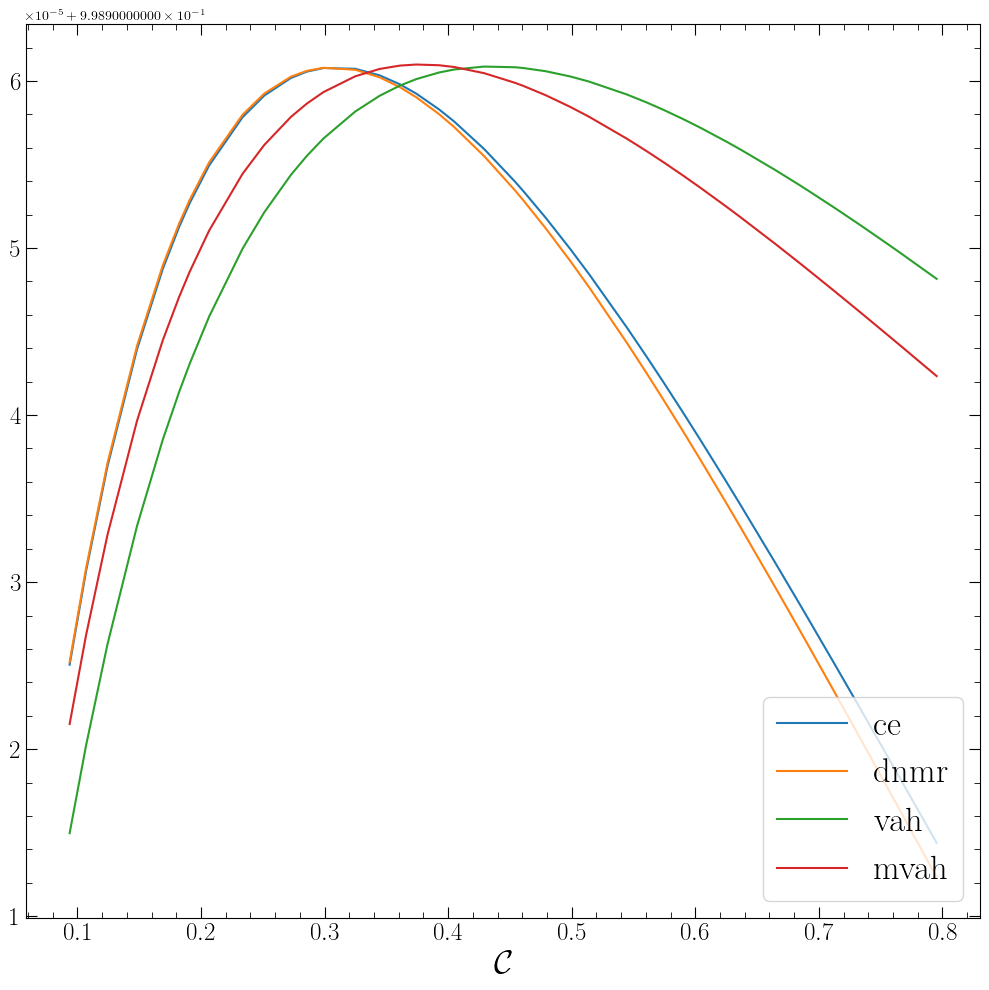

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, name in enumerate(names):
    ax.plot(GP_design_points[sort_arr[:,0]], np.exp(posteriors[name]), label=name)
ax.legend(loc='lower right', fontsize=25)
costumize_axis(ax, r'$\mathcal C$', '')
fig.tight_layout()

In [11]:
emulators = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
read_in_emulator = False
if read_in_emulator:
    pass
else:
    for hydro in emulators:
        local_list = []
        print('\tTraining GP for ' + hydro)
        for i in range(1, 4):
            kernel = 1 * krnl.RBF(
                length_scale=GP_design_range, 
                length_scale_bounds=np.outer(np.array(GP_design_range), (1e-5, 1e1))) #+ \
                # krnl.WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e1))
            GPR = gpr(kernel=kernel, n_restarts_optimizer=20)
            print('\t\tTraining GP:', i)
            if hydro == 'ce':
                GPR.fit(GP_design_points, ce_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, ce_simulation[:,i])))
            elif hydro == 'dnmr':
                GPR.fit(GP_design_points, dnmr_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, dnmr_simulation[:,i])))
            elif hydro == 'vah':
                GPR.fit(GP_design_points, vah_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, vah_simulation[:,i])))
            elif hydro == 'mvah':
                GPR.fit(GP_design_points, mvah_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, mvah_simulation[:,i])))
            else:
                print('Invalid hydro type')
                break
            local_list.append(GPR)
        emulators[hydro] = local_list

	Training GP for ce
		Training GP: 1
GP score: 1.000
		Training GP: 2
GP score: 1.000
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GP score: 1.000
	Training GP for dnmr
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GP score: 1.000
		Training GP: 2
GP score: 1.000
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GP score: 1.000
	Training GP for vah
		Training GP: 1
GP score: 1.000
		Training GP: 2
GP score: 1.000
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GP score: 1.000
	Training GP for mvah
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GP score: 1.000
		Training GP: 2
GP score: 1.000
		Training GP: 3
GP score: 1.000


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [ ]:
def PlotGPDesignPointsAgainstSimulation(emulators, design_points):
    passc

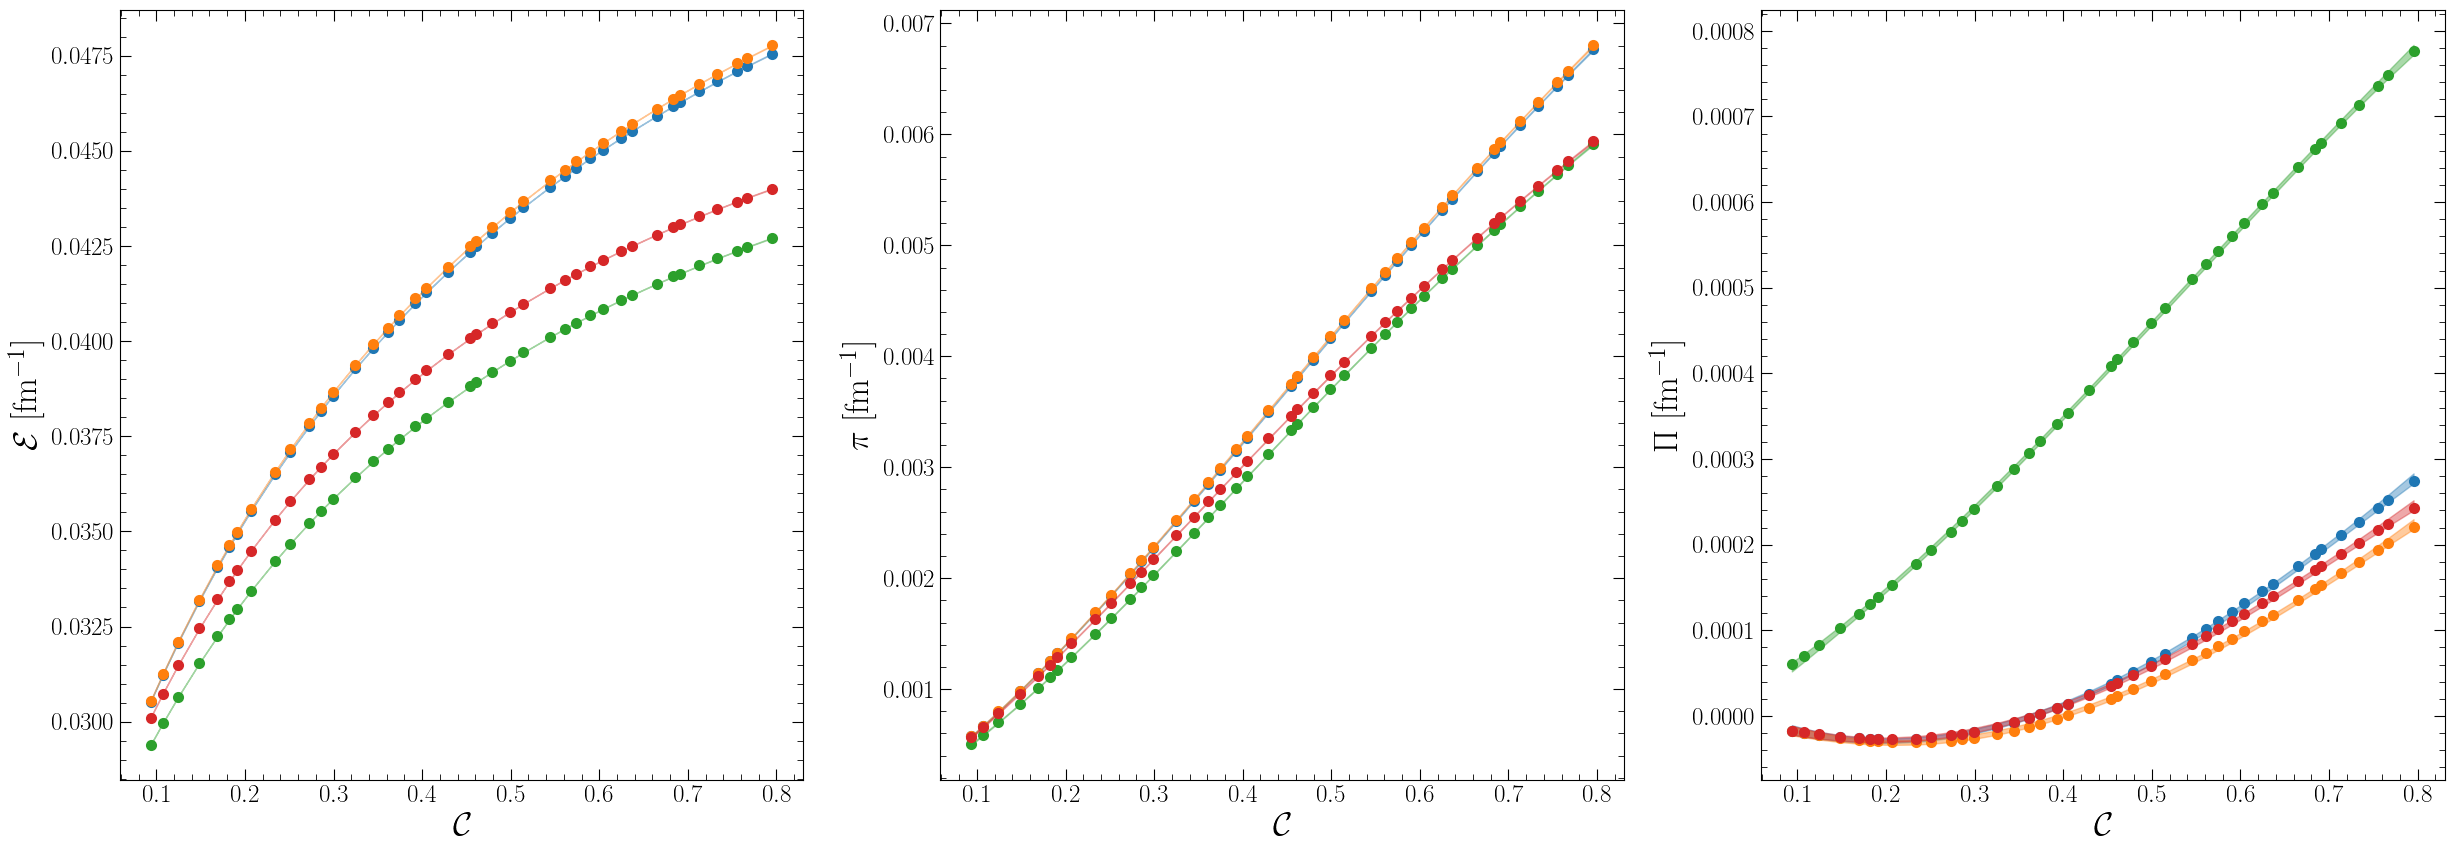

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.patch.set_facecolor('white')

names = ['ce', 'dnmr','vah','mvah']
observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
cmap = get_cmap(10, 'tab10')
for i, name in enumerate(names):
    for j, observable in enumerate(observables):
        ax[j].scatter(GP_design_points[sort_arr[:,0]], hydro_lists[i,sort_arr[:,0],j+1], lw=2, color=cmap(i), marker='o', label=name)
        #ax[i, j].scatter(GP_design_points, emulators[name][j].predict(GP_design_points, return_std=True)[0], lw=2, color='black', marker='x', label=name)
        emul, err = emulators[name][j].predict(GP_design_points, return_std=True)
        emul = emul.reshape(-1,)[sort_arr[:,0]]
        err = err[sort_arr[:,0]]
        ax[j].fill_between(GP_design_points.reshape(-1,)[sort_arr[:,0]], emul + err, emul - err, color=cmap(i), alpha=0.4)
        costumize_axis(ax[j], r'$\mathcal C$', observable)

In [96]:
#validation
number_validation_points = 10
tau_f = np.full((number_validation_points, 1), 15)
eta_s = np.array(GP_parameter_ranges[0,0] + np.random.rand(number_validation_points, 1) * GP_design_range[0])
eta_s = eta_s[np.argsort(eta_s, 0)[:,0]]
validation_points = eta_s.reshape(-1, 1)

names = ['ce', 'dnmr', 'vah', 'mvah']

validation_data = {}
for i, name in enumerate(names):
    params['hydro_type'] = i
    validation_data[name] = ProcessHydro(GP_parameter_names, validation_points)

GP_predictions = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
for name in names:
    for i in range(3):
        GP_x_prediction, GP_x_err = emulators[name][i].predict(validation_points, return_std=True)
        GP_predictions[name].append(np.hstack((GP_x_prediction, GP_x_err.reshape(-1,1))))

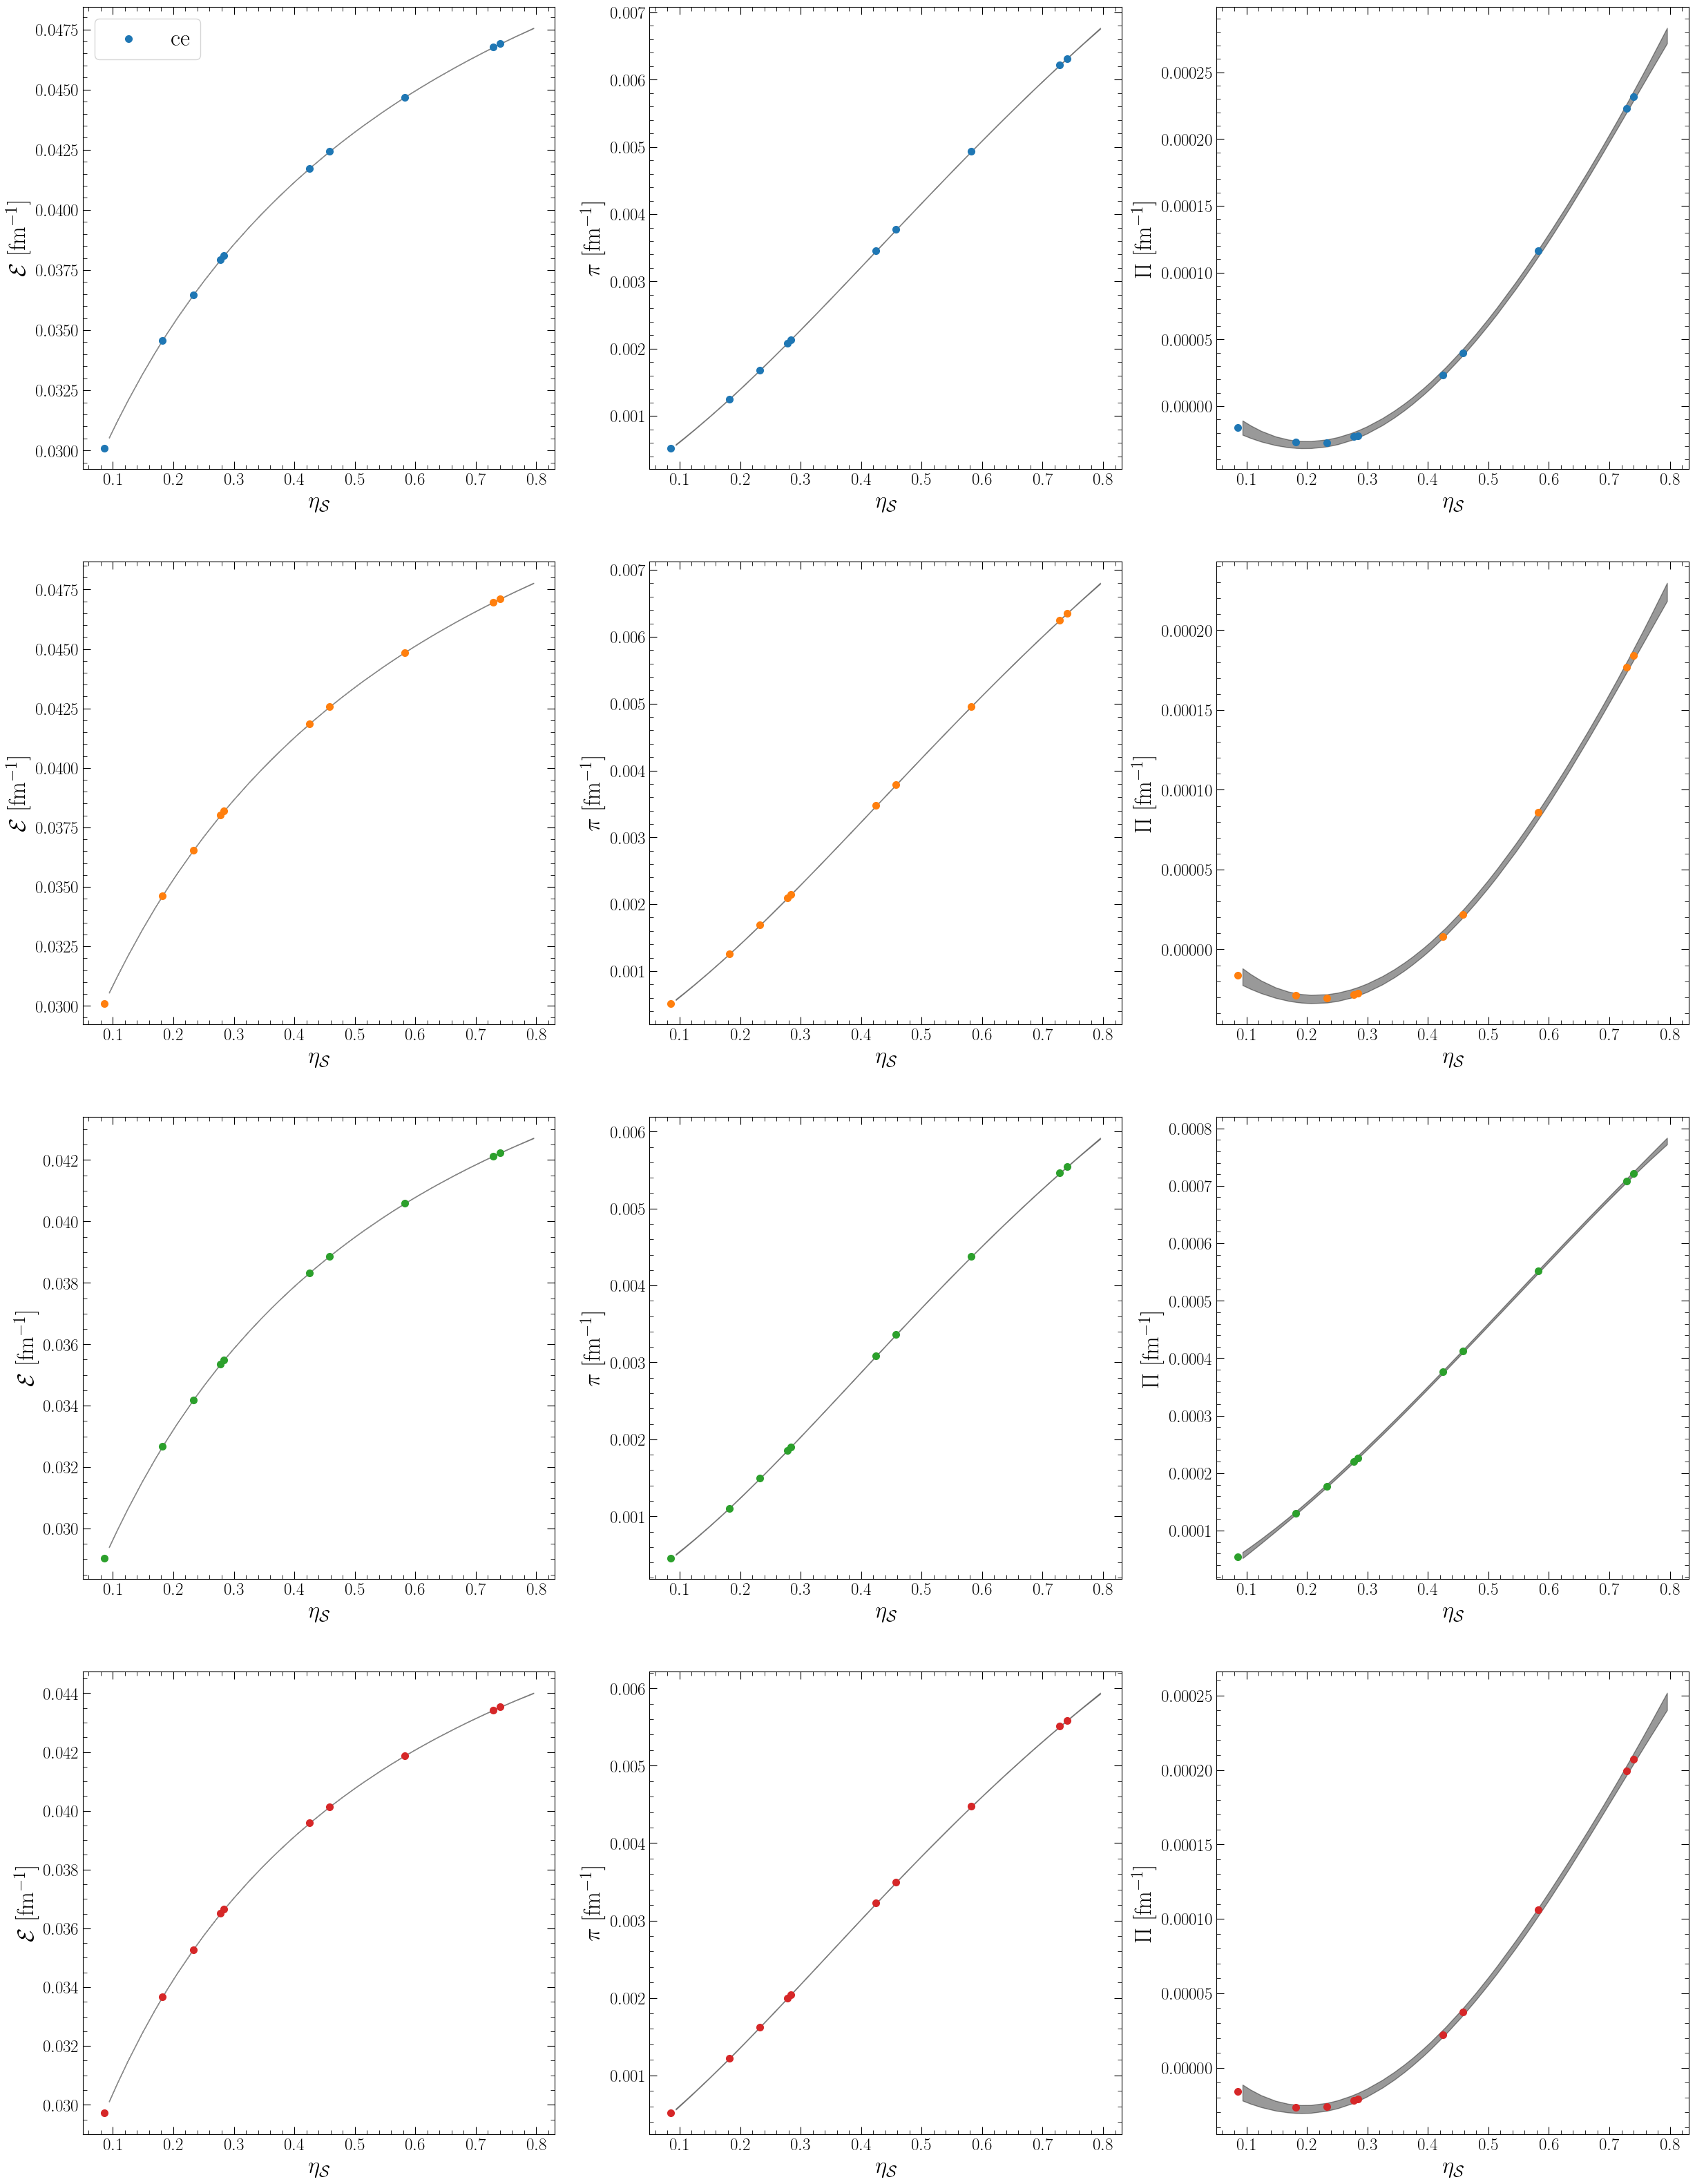

In [122]:
fig, ax = plt.subplots(4, 3, figsize=(30,40))
fig.patch.set_facecolor('white')

names = ['ce', 'dnmr','vah','mvah']
observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
cmap = get_cmap(10, 'tab10')
for i, name in enumerate(names):
    for j, observable in enumerate(observables):
        # GP data
        # ax[i,j].scatter(GP_design_points[sort_arr[:,0]], hydro_lists[i,sort_arr[:,0],j+1], lw=2, color='gray', marker='o', label=name)
        emul, err = emulators[name][j].predict(GP_design_points, return_std=True)
        emul = emul.reshape(-1,)[sort_arr[:,0]]
        err = err[sort_arr[:,0]]
        ax[i, j].fill_between(GP_design_points.reshape(-1,)[sort_arr[:,0]], emul + err, emul - err, color='black', alpha=0.4)
        # Validation data
        ax[i,j].scatter(validation_points[:,0], np.array(validation_data[name])[:, j+1], lw=2, color=cmap(i), label=name)
        # ax[i,j].fill_between(validation_points[:,0], GP_predictions[name][j][:, 0] + GP_predictions[name][j][:, 1], GP_predictions[name][j][:, 0] - GP_predictions[name][j][:, 1], color=cmap(i), alpha=0.5)
        costumize_axis(ax[i,j], r'$\eta_\mathcal S$ ', observable)
ax[0, 0].legend(loc=0, fontsize=25)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.patch.set_facecolor('white')

names = ['ce', 'dnmr','vah','mvah']
observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
cmap = get_cmap(10, 'tab10')
for i, name in enumerate(names):
    for j, observable in enumerate(observables):
        ax[j].scatter(validation_points[:,0], np.array(validation_data[name])[:, j+1], lw=2, color=cmap(i), label=name)
        ax[j].fill_between(validation_points[:,0], GP_predictions[name][j][:, 0] + GP_predictions[name][j][:, 1], GP_predictions[name][j][:, 0] - GP_predictions[name][j][:, 1], color=cmap(i), alpha=0.5)
        costumize_axis(ax[j], r'$\eta_\mathcal S$ ', observable)
ax[0].legend(loc=0, fontsize=25)

In [ ]:
# Check error distribution to make sure it conforms to out assumptions
number_validation_points = 100
tau_f = np.full((number_validation_points, 1), 15)
eta_s = np.array(GP_parameter_ranges[0,0] + np.random.rand(number_validation_points, 1) * GP_design_range[0])
eta_s = eta_s[np.argsort(eta_s, 0)[:,0]]
validation_points = np.hstack((eta_s, tau_f))

validate = False
if validate:
    validation_data = {}
    for i, name in enumerate(names):
        params['hydro_type'] = i
        validation_data[name] = ProcessHydro(GP_parameter_names, validation_points)

    GP_predictions = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for name in names:
        for i in range(3):
            GP_x_prediction, GP_x_err = emulators[name][i].predict(validation_points, return_std=True)
            GP_predictions[name].append(np.hstack((GP_x_prediction, GP_x_err.reshape(-1,1))))

In [ ]:
if validate:
    normalized_discrepenancy = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for i, name in enumerate(names):
        for j in range(3):
            normalized_discrepenancy[name].append((GP_predictions[name][j][:,0] - np.array(validation_data[name])[:,j+1]) / GP_predictions[name][j][:,1])

    residuals = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for i, name in enumerate(names):
        for j in range(3):
            residuals[name].append((GP_predictions[name][j][:,0] - np.array(validation_data[name])[:,j+1]))

In [ ]:
if validate:
    fig1, ax1 = plt.subplots(4, 3, figsize=(40, 30))
    fig1.patch.set_facecolor('white')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax1[i, j].hist(residuals[name][j],color='brown')
            ax1[i, j].set_xlabel(observable)

    fig2, ax2 = plt.subplots(4, 3, figsize=(40, 30))
    fig2.patch.set_facecolor('white')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax2[i, j].hist(normalized_discrepenancy[name][j], bins=15, range=[-3,3], color='brown')
            ax2[i, j].set_xlabel(observable)

In [123]:
def predict_observable(model_parameters, hydro_name, GP_emulator):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,) 
    hydro_name          - string
    GP_emulator         - dictionary
    '''
    means = []
    variances = []
    for i in range(3):
        prediction, error = GP_emulator[hydro_name][i].predict(np.array(model_parameters).reshape(-1, len(model_parameters)), return_std=True)
        means.append(prediction)
        variances.append(error ** 2)
    return np.hstack(means), np.diag(np.array(variances).flatten())

In [47]:
x, y = predict_observable([0.33], 'ce', emulators)
print(x, y)

[[ 3.94275945e-02  2.56079105e-03 -1.02553326e-05]] [[1.17670771e-11 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.76401473e-12 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.87646368e-12]]


# Bayesian Inference
The usual

In [124]:
def GetTemperature(e, m):
    def Eeq(T, z):
        if z == 0:
            return 3.0 * T ** 4 / np.pi ** 2
        else:
            return (3.0 * T ** 4 / np.pi ** 2) * (z ** 2 * special.kn(2, z) / 2.0 + z ** 3 * special.kn(1, z) / 6.0)

    Tmin = 0.001 / 0.197
    Tmax = 2.0 / 0.0197
    n = 0; flag = True
    Tmid = 0
    while flag and n <= 2000:
        Tmid = (Tmin + Tmax) / 2.0
        emid = Eeq(Tmid, m / Tmid)
        emin = Eeq(Tmin, m / Tmin)
        if np.fabs(emid - e) < 1e-6:
            break
        if (emid - e) * (emin - e) <= 0:
            Tmax = Tmid
        else:
            Tmin = Tmid
        n += 1
        if n == 1:
            Tcopy = Tmid
        if n > 4:
            if np.fabs(Tcopy - Tmid) < 1e-6:
                flag = False
            Tcopy = Tmid

    return Tmid * 0.197

In [125]:
GetTemperature(12.4395115821926900, 0.2 / 0.197)

0.4999998869672419

In [130]:
true_parameters = [5 / (4 * np.pi)]
params['hydro_type'] = 4
true_observables = ProcessHydro(GP_parameter_names, true_parameters)
true_temperature = GetTemperature(true_observables[1], params['mass']) / 0.197

#true_observable_errors = [np.sqrt(true_observables[1]), np.sqrt(true_temperature ** 4 * np.fabs(true_observables[2])),np.sqrt(true_temperature ** 4 * np.fabs(true_observables[3]))]

In [163]:
true_observable_errors = 0.0005 * np.fabs(true_observables[1:4])

In [132]:
print(true_parameters)
print(true_observables)
print(true_observable_errors)

[0.3978873577297384]
[12.095, 0.0386885652323728, 0.002920848595419467, 9.960166529866116e-06]
[1.93442826e-03 1.46042430e-04 4.98008326e-07]


In [155]:
def log_prior(model_parameters, design_range):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array with shape (n,). Value of parameters used to evaluate model
    design_range        - 2d-array with shape (n,2). Give upper and lower limits of parameter values
    '''
    X  = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= np.array(design_range)[:,0])
    upper = np.all(X <= np.array(design_range)[:,1])

    if (lower and upper):
        return 0
    else:
        return -np.inf

def log_likelihood(y, cov):
    '''
    Parameters:
    ------------
    y   - 1d-array with shape (n,)
    cov - 2d-array with shape (n,n)
    '''
    # Use Cholesky decomposition for efficient lin alg algo
    L, info = lapack.dpotrf(cov, clean=True)

    if (info < 0):
        raise print('Error occured in computation of Cholesky decomposition')

    # Solve equation L*b=y
    b, info = lapack.dpotrs(L, np.array(y))

    if (info != 0):
        raise print('Error in inverting matrix equation')

    if np.all(L.diagonal() > 0):
        return -0.5 * np.dot(y, b) - np.log(L.diagonal()).sum()
    else:
        raise print('Diagonal has negative entry')

def log_posterior(model_parameters, design_range, true_observables, true_errors, hydro_name, GP_emulator):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,)
    design_range        - 2d-array like (n,2)
    hydro_name          - string containing hydro theory: 'ce', 'dnmr', 'vah', 'mvah'
    GP_emulatr          - dictionary(hydro_name: emulator_list), 
                            emulator_list[0] - energery density
                            emulator_list[1] - shear stress
                            emulator_list[2] - bulk stress
    '''
    emulation_values, emulation_error = predict_observable(model_parameters, hydro_name, GP_emulator) 

    y = np.array(emulation_values) - np.array(true_observables)
    cov = emulation_error + np.diag(true_errors)

    return log_prior(model_parameters, design_range) + log_likelihood(y.flatten(), cov)


In [134]:
nparams = len(GP_parameter_names)
nwalkers = 20 * nparams
nburn = 1000
nsteps = 10000

names = ['ce', 'dnmr', 'vah', 'mvah']
MCMC_samplers = {}
for i, name in enumerate(names):
    print(f"Computing for hydro theory: {name}")
    starting_guesses = GP_parameter_ranges[:,0] + np.random.rand(nwalkers, nparams) * GP_design_range
    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior, args=(GP_parameter_ranges, true_observables[1:4], true_observable_errors, name, emulators))
        print('burn in sampling started')    
        pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
        print('Burn in completed.')
        print("Now running the samples")
        sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
    sampler_df = pd.DataFrame(sampler.get_chain(flat=True, discard=nburn), columns=GP_parameter_names_math)
    MCMC_samplers[name] = sampler_df

Computing for hydro theory: ce
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers
burn in sampling started


100%|██████████| 1000/1000 [00:10<00:00, 95.25it/s]


Mean acceptance fraction: 0.822 (in total 20000 steps)
Burn in completed.
Now running the samples


100%|██████████| 10000/10000 [01:43<00:00, 96.17it/s]

Mean acceptance fraction: 0.825 (in total 200000 steps)
Computing for hydro theory: dnmr
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers


burn in sampling started


100%|██████████| 1000/1000 [00:10<00:00, 96.35it/s]


Mean acceptance fraction: 0.824 (in total 20000 steps)
Burn in completed.
Now running the samples


100%|██████████| 10000/10000 [01:44<00:00, 95.39it/s]

Mean acceptance fraction: 0.827 (in total 200000 steps)
Computing for hydro theory: vah
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers


burn in sampling started


100%|██████████| 1000/1000 [00:10<00:00, 96.70it/s]


Mean acceptance fraction: 0.817 (in total 20000 steps)
Burn in completed.
Now running the samples


100%|██████████| 10000/10000 [01:43<00:00, 96.44it/s]

Mean acceptance fraction: 0.817 (in total 200000 steps)
Computing for hydro theory: mvah
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers


burn in sampling started


100%|██████████| 1000/1000 [00:10<00:00, 96.34it/s]


Mean acceptance fraction: 0.824 (in total 20000 steps)
Burn in completed.
Now running the samples


100%|██████████| 10000/10000 [01:44<00:00, 95.83it/s]

Mean acceptance fraction: 0.826 (in total 200000 steps)


In [ ]:
sampler_df.head()

In [24]:
observables

['$\\mathcal E$ [fm$^{-1}$]', '$\\pi$ [fm$^{-1}$]', '$\\Pi$ [fm$^{-1}$]']

## My own sampler

In [164]:
steps = 1000
sampler_params = np.linspace(GP_parameter_ranges[0,0], GP_parameter_ranges[0,1], steps)
posteriors = {}
for i, name in enumerate(names):
    final_arr = np.zeros(steps)
    for j in range(steps):
        final_arr[j] = log_posterior([sampler_params[j]], GP_parameter_ranges, true_observables[1:4], true_observable_errors, name, emulators)
    posteriors[name] = final_arr

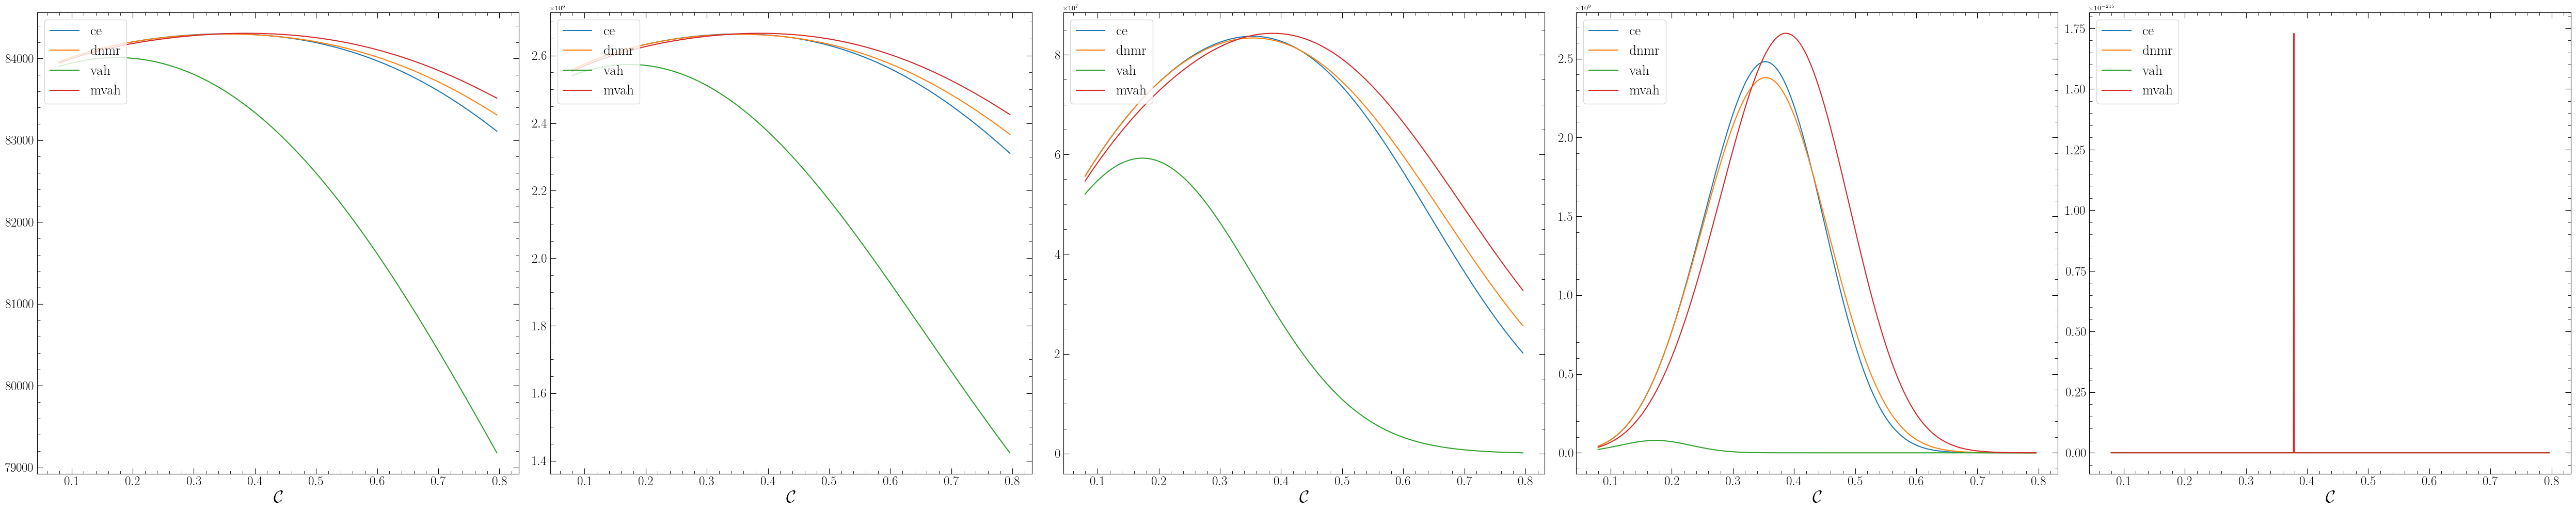

In [172]:
fig, ax = plt.subplots(1, 5, figsize=(50, 10))
alpha_error = [0.5, 0.05, 0.005, 0.0005, 0]
for k in range(5):
    steps = 1000
    sampler_params = np.linspace(GP_parameter_ranges[0,0], GP_parameter_ranges[0,1], steps)
    posteriors = {}
    for i, name in enumerate(names):
        final_arr = np.zeros(steps)
        for j in range(steps):
            final_arr[j] = log_posterior([sampler_params[j]], GP_parameter_ranges, true_observables[1:4], alpha_error[k] * np.array(true_observables[1:4]), name, emulators)
        posteriors[name] = final_arr

    for i, name in enumerate(names):
        ax[k].plot(sampler_params, np.exp(posteriors[name]), label=name)
    ax[k].legend(loc='upper left', fontsize=20)
    costumize_axis(ax[k], r'$\mathcal C$', '')
fig.tight_layout()

## Validation: Autocorrelation

In [135]:
def autocorrelation(chain, max_lag=100):
    dim = len(chain)
    acorr = np.empty(max_lag+1)
    if max_lag > dim / 5:
        print('max_lag is more than a 5th the chain length')
    
    chain1d = chain - np.average(chain)
    for lag in range(max_lag + 1):
        unshifted = None
        shifted = chain[lag:]
        if lag == 0:
            unshifted = chain1d
        else:
            unshifted = chain[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acorr[lag] = np.dot(shifted, unshifted) / normalization
    return acorr

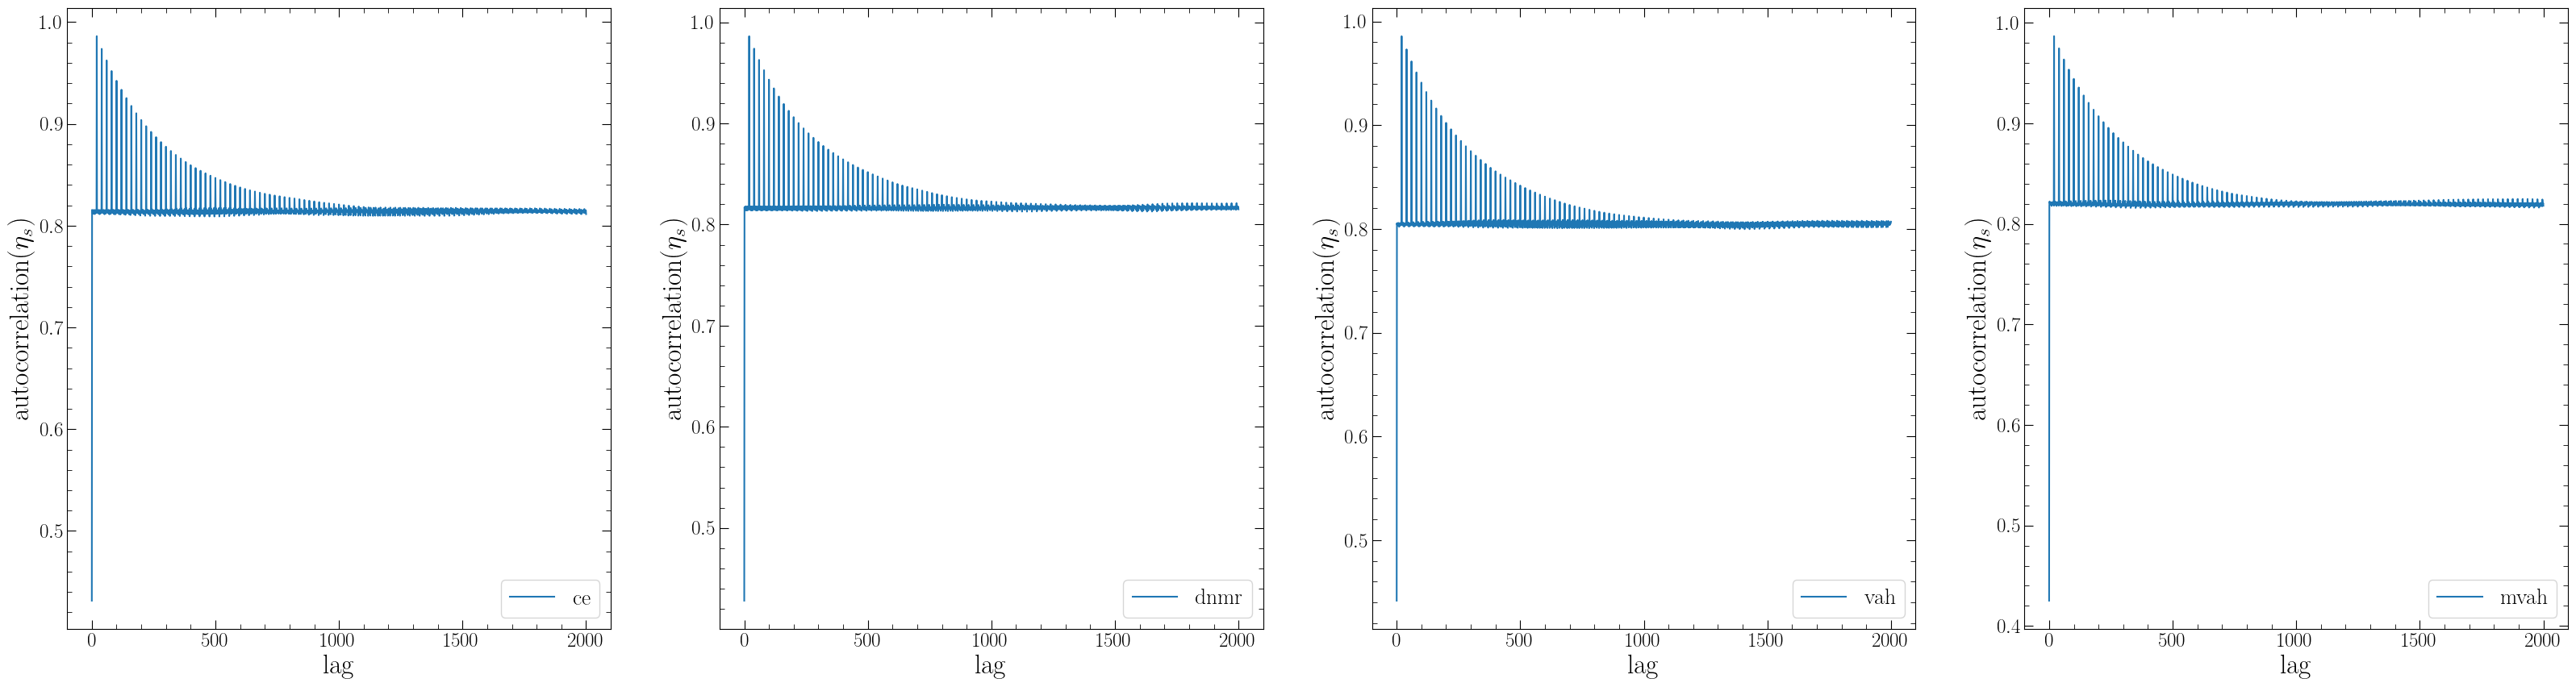

In [174]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
fig.patch.set_facecolor('white')
for irow, name in enumerate(names):
    for jcol, param in enumerate(GP_parameter_names_math):
        acorr = autocorrelation(MCMC_samplers[name].iloc[:,jcol].to_numpy(), 2000)
        ax[irow].plot(acorr, label=name)
        costumize_axis(ax[irow], 'lag', 'autocorrelation(' + param + ')')
        ax[irow].legend(loc='lower right', fontsize=20)
    

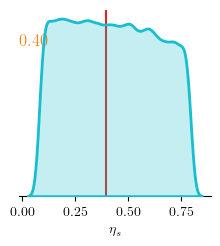

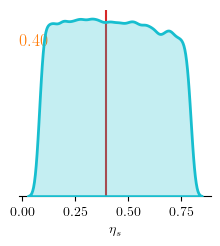

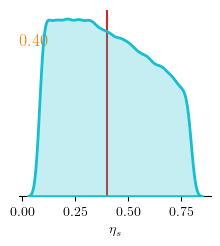

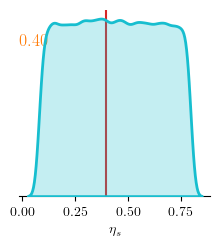

In [139]:
names = ['ce', 'dnmr', 'vah', 'mvah']
for i, name in enumerate(names):
    g = sns.PairGrid(MCMC_samplers[name].iloc[:,:], corner=True, diag_sharey=False)
    g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
    g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
    for n in range(nparams):
        ax=g.axes[n][n]
        ax.axvline(x=true_parameters[n], ls='-', c=sns.color_palette()[3], label='Truth')
        ax.text(0,0.8,s= f'{true_parameters[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[1], fontsize=12)
    # g.axes.legend(loc='best', fontsize=10)
    # g.axes.text(0.5 ,0.8, s=name, color=sns.color_palette()[1], fontsize=12)

In [37]:
mcmc

array([14.95496767, 14.96412202, 19.99929537])

In [41]:
from IPython.display import display, Math
parameter_names = [r'\eta/\mathcal{S}', r'\tau_f']
for name in names:
    print(f'Prediction of {name}:')
    for i in range(num_parameters_in_GP):
        mcmc = np.percentile(MCMC_samplers[name].to_numpy()[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        output = '{{{1}}}= {2:.3f}^{{+{3:.3f}}}_{{-{4:.3f}}}'.format(name, parameter_names[i], mcmc[1], q[1], q[0])
        display(Math(output))
    print('\n')

Prediction of ce:


<IPython.core.display.Math object>

<IPython.core.display.Math object>



Prediction of dnmr:


<IPython.core.display.Math object>

<IPython.core.display.Math object>



Prediction of vah:


<IPython.core.display.Math object>

<IPython.core.display.Math object>



Prediction of mvah:


<IPython.core.display.Math object>

<IPython.core.display.Math object>